# OverSampling

## Load modules

In [87]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [ ]:
# Local PC로 실습하는 경우 실행 x / 단 작업경로를 LGES2023_CNN으로 맞춰주기
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/LGES2023_CNN

In [88]:
def plot_representation(X, y, X_syn=None, y_syn=None, method='real'):
    # 정상 데이터, 이상 데이터 추출
    y_normal, y_anomaly = y[y==0].dropna(), y[y==1].dropna()
    X_normal, X_anomaly = X.loc[list(y_normal.index), :], X.loc[list(y_anomaly.index), :]
    
    # Sampling 결과 비교
    # method == 'real': 실제 데이터만 시각화
    # method != 'real': Sampling 결과와 실제 데이터 시각화 비교
    if method.lower() != 'real':
        fig = plt.figure(figsize=(16, 8))
        ax1 = fig.add_subplot(1, 2, 1)
    else:
        fig = plt.figure(figsize=(8, 8))
        ax1 = fig.add_subplot(1, 1, 1)

    # create_dataset 으로 생성된 데이터 시각화
    # 실제 데이터 사용시 2차원으로 축소 후 본 함수 사용
    # column 명을 정확히 기입해주어야함
    ax1.scatter(X_normal['X1'], X_normal['X2'], alpha=0.3, c='blue', label='Normal')
    ax1.scatter(X_anomaly['X1'], X_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.get_xaxis().tick_bottom()
    ax1.get_yaxis().tick_left()

    plt.xlim((-5, 5))
    plt.ylim((-5, 5))
    plt.legend()
    plt.tight_layout()
    plt.title('Real', fontsize=20)

    if X_syn is not None:
        ax2 = fig.add_subplot(1, 2, 2)
        y_syn_normal, y_syn_anomaly = y_syn[y_syn==0].dropna(), y_syn[y_syn==1].dropna()
        X_syn_normal, X_syn_anomaly = X_syn.loc[list(y_syn_normal.index), :], X_syn.loc[list(y_syn_anomaly.index), :]

        ax2.scatter(X_syn_normal['X1'], X_syn_normal['X2'], alpha=0.3, c='blue', label='Normal')
        ax2.scatter(X_syn_anomaly['X1'], X_syn_anomaly['X2'], alpha=0.3, c='red', label='Anomaly')

        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
        ax2.get_xaxis().tick_bottom()
        ax2.get_yaxis().tick_left()

        plt.xlim((-5, 5))
        plt.ylim((-5, 5))
        plt.legend()
        plt.tight_layout()
        plt.title(method, fontsize=20)
        
    plt.show()

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    혼동 행렬을 시각화하는 함수입니다.

    인자:
    cm : numpy.ndarray
        혼동 행렬
    classes : list
        클래스 레이블의 이름을 포함하는 리스트
    normalize : bool, optional (default=False)
        True로 설정하면 혼동 행렬을 정규화합니다.
    title : str, optional (default='Confusion Matrix')
        시각화의 제목
    cmap : matplotlib colormap, optional (default=plt.cm.Blues)
        시각화에 사용할 컬러맵

    반환값:
    None
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
def create_dataset(n_samples=2000,
                weights=(0.8, 0.2),
                n_classes=2,
                class_sep=1,
                n_cluster=1,
                random_state=0):
    df = make_classification(n_samples=n_samples, n_features=2,
                            n_informative=2, n_redundant=0, n_repeated=0,
                            n_classes=n_classes,
                            n_clusters_per_class=n_cluster,
                            weights=list(weights),
                            class_sep=class_sep, random_state=random_state)
    
    X = pd.DataFrame(df[0], columns=['X1', 'X2'])
    y = pd.DataFrame(df[1], columns=['y'])
    return X, y

def calculate_classification_metrics(true_labels, predicted_labels):
    """
    true값과 pred값을 입력받아 accuracy, precision, recall, micro F1-score, macro F1-score를 계산하고 출력하는 함수입니다.

    인자:
    true_labels : array-like of shape (n_samples,)
        실제 레이블
    predicted_labels : array-like of shape (n_samples,)
        예측된 레이블
    """
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    return accuracy, precision, recall, f1

In [89]:
X_syn, y_syn = create_dataset(n_samples=5000, weights=(0.9, 0.1), n_cluster=1, random_state=711)

In [90]:
pd.concat((X_syn,y_syn),axis=1).head()

,X1,X2,y
0,-0.160925,1.086261,0
1,0.742875,1.565160,0
2,-0.731222,1.576781,0
3,-0.587168,-0.450631,0
4,-0.344950,-0.821397,0


In [91]:
X_syn.shape, y_syn.shape

((5000, 2), (5000, 1))

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_syn,y_syn, random_state=2023)

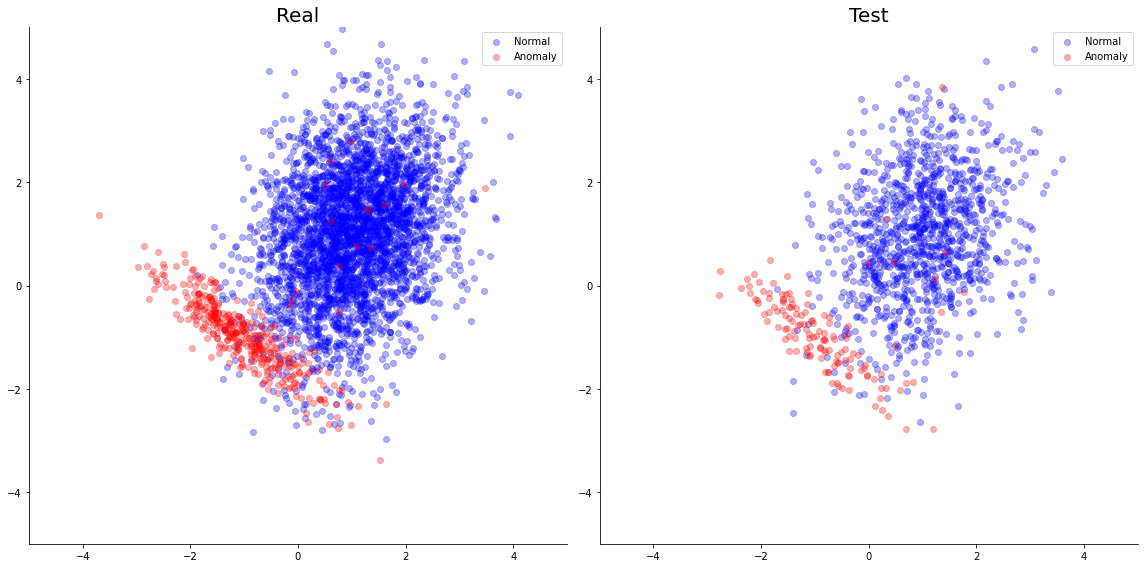

In [93]:
plot_representation(X_train, y_train, X_test, y_test, method='Test')

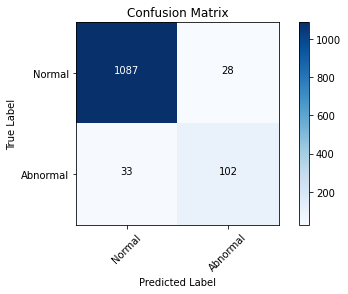

Accuracy : 0.9512
Precision : 0.8776
Recall : 0.8652
F1-score : 0.8713


In [94]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
dt_tree.fit(X_train, y_train)

y_pred_test = dt_tree.predict(X_test)
cm_baseline = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_baseline, classes)
_, _, _, f1_baseline = calculate_classification_metrics(y_test, y_pred_test)

### Random Over Sampling(ROS)

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html#imblearn.over_sampling.RandomOverSampler

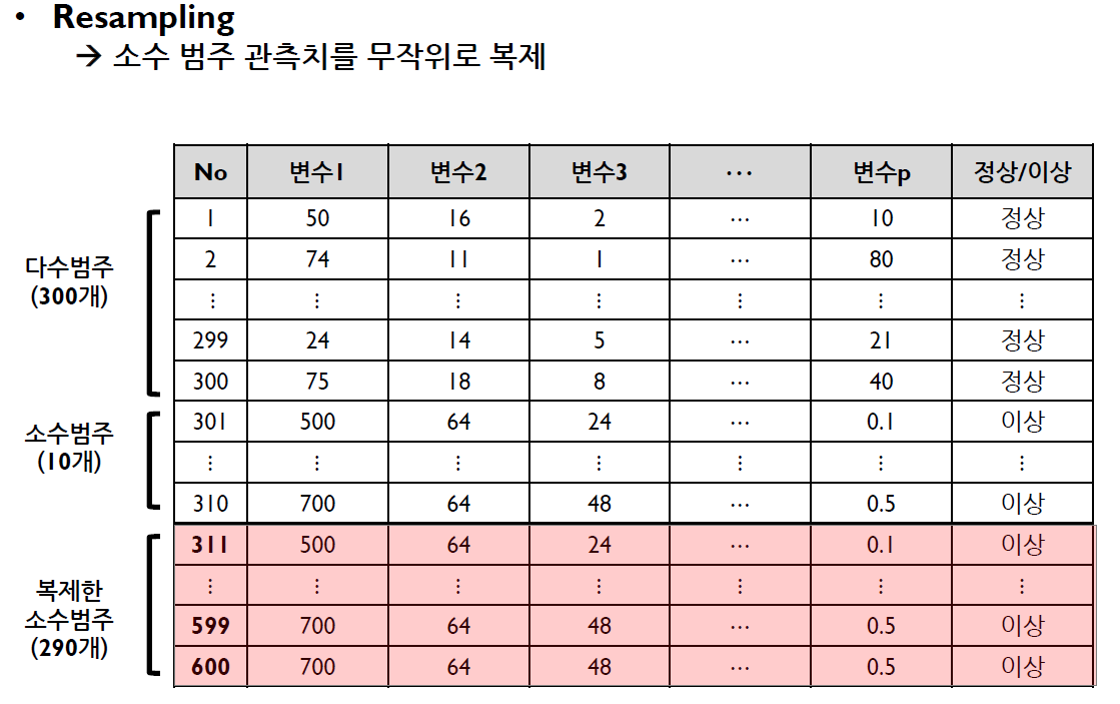

In [95]:
Image.open('./imgs/img5.png')

In [96]:
from imblearn.over_sampling import RandomOverSampler

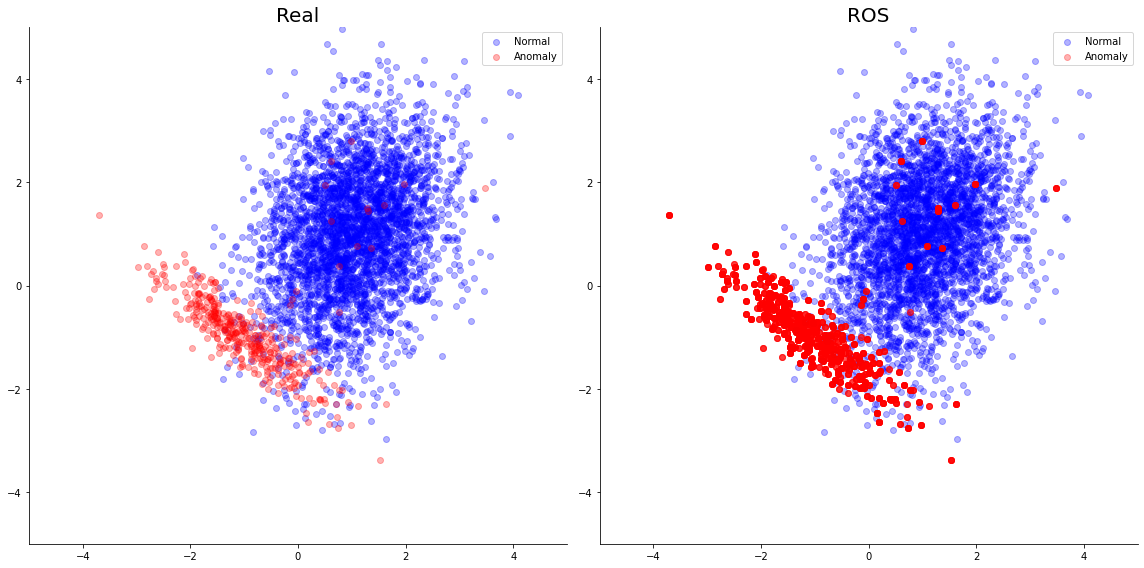

In [97]:
ros = RandomOverSampler(sampling_strategy='auto',
                         random_state=2023,
                         shrinkage=None) # sample에 noise 추가
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'ROS')

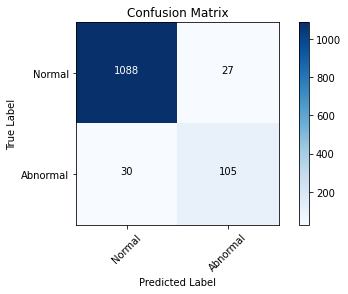

Accuracy : 0.9544
Precision : 0.8843
Recall : 0.8768
F1-score : 0.8805


In [98]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
ros_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = ros_tree.predict(X_test)
cm_ros = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_ros, classes)
_, _, _, f1_ros = calculate_classification_metrics(y_test, y_pred_test)

## SMOTE

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#imblearn.over_sampling.SMOTE

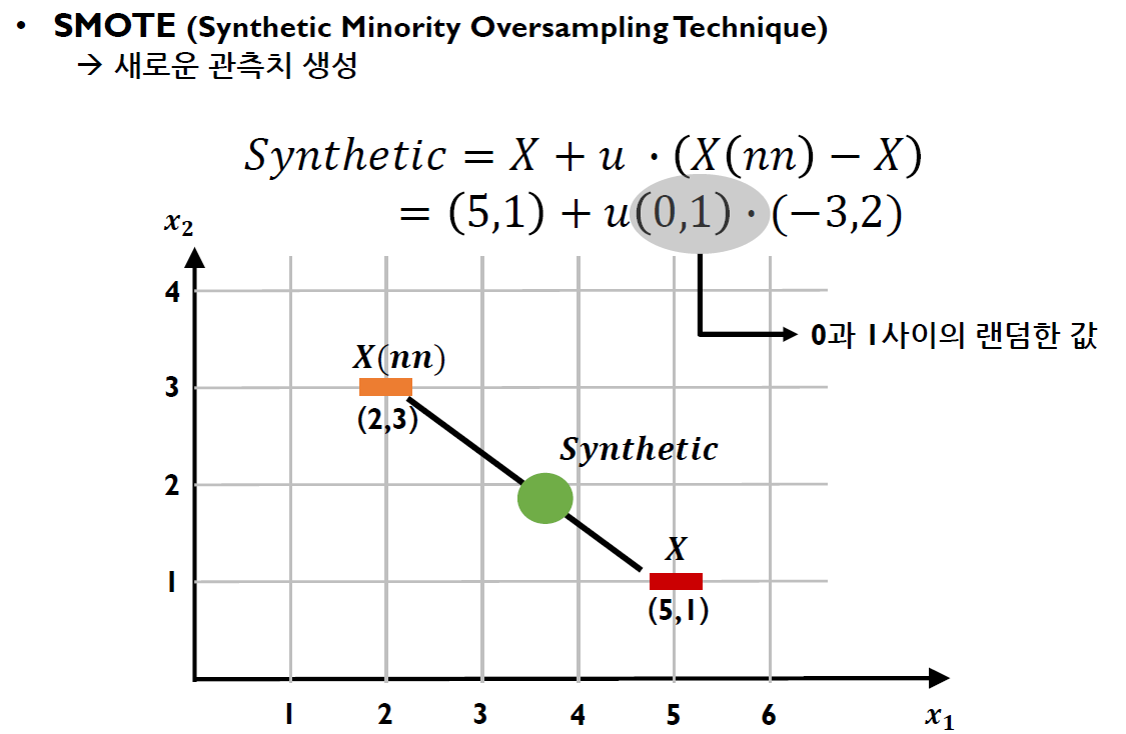

In [99]:
Image.open('./imgs/img6.png')

In [100]:
from imblearn.over_sampling import SMOTE

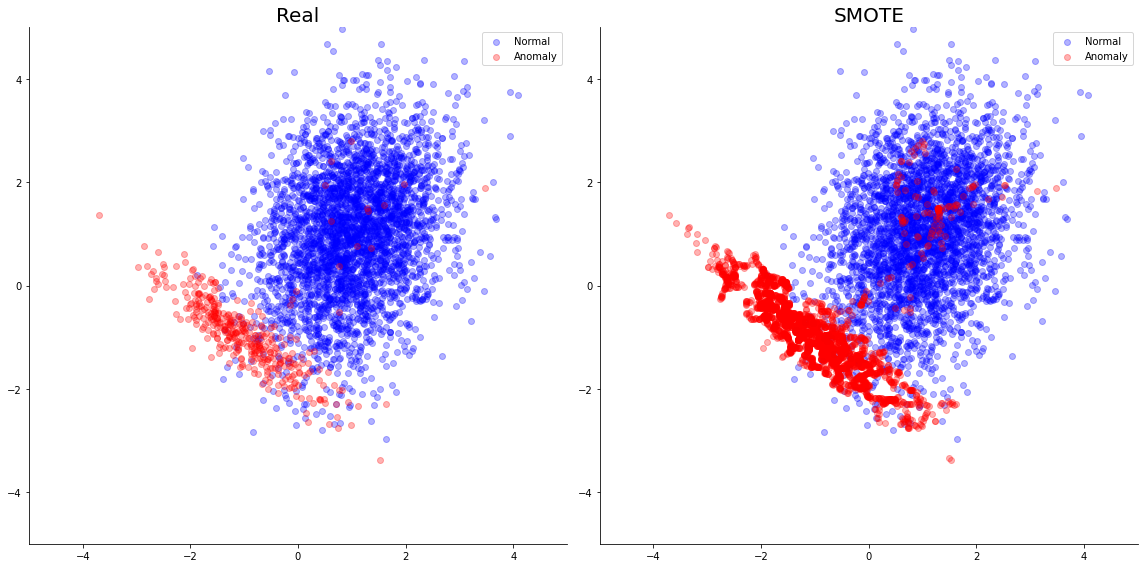

In [101]:
smote = SMOTE(sampling_strategy='auto',
              random_state=2023,
              k_neighbors=5)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'SMOTE')

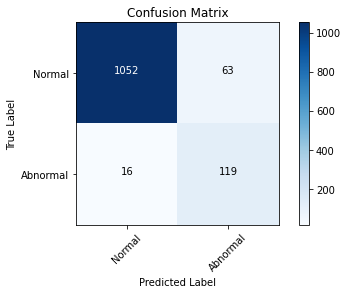

Accuracy : 0.9368
Precision : 0.8194
Recall : 0.9125
F1-score : 0.8573


In [102]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
smote_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = smote_tree.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_smote, classes)
_, _, _, f1_smote = calculate_classification_metrics(y_test, y_pred_test)

## Borderline-SMOTE

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html#imblearn.over_sampling.BorderlineSMOTE

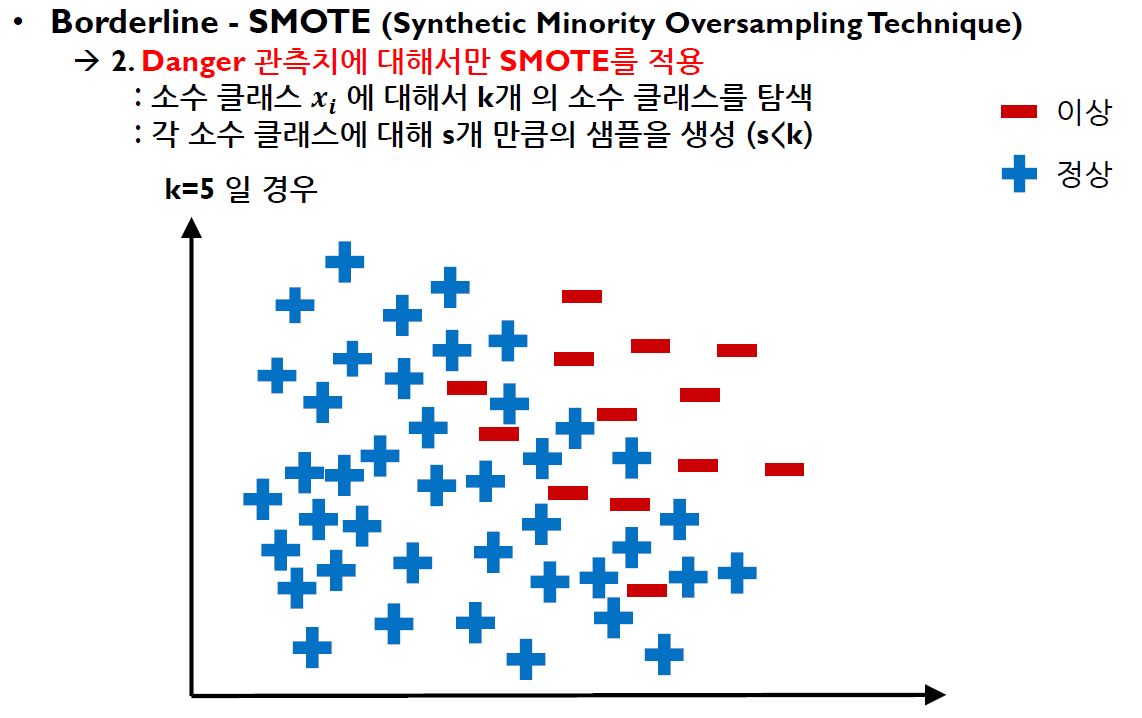

In [103]:
Image.open('./imgs/img7.png')

In [104]:
from imblearn.over_sampling import BorderlineSMOTE

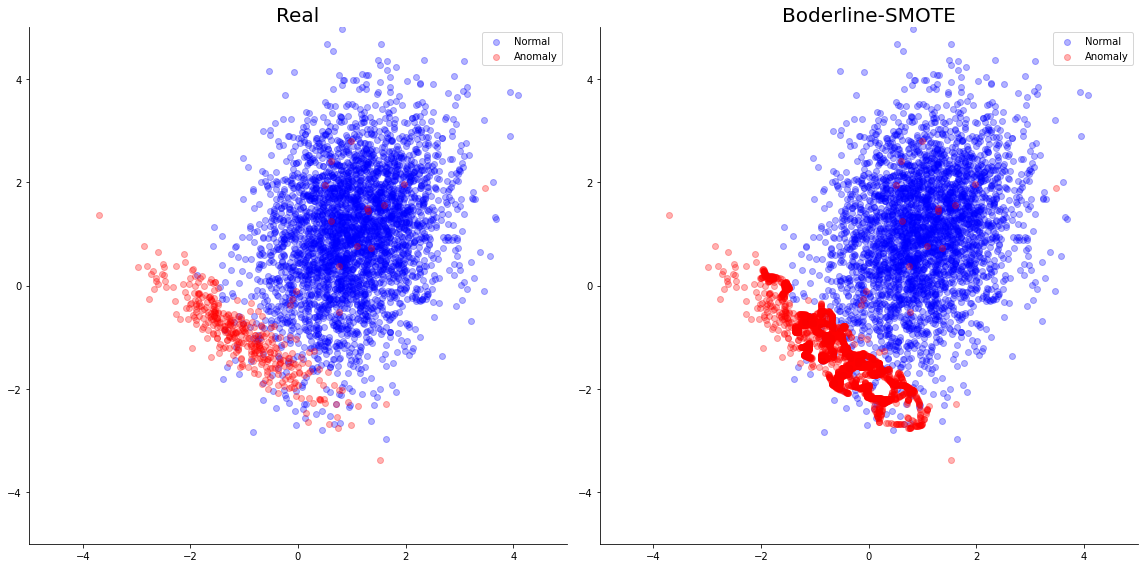

In [105]:
bl_smote = BorderlineSMOTE(sampling_strategy='auto',
                           random_state=2023,
                           k_neighbors=5,
                           m_neighbors=2) # synthetic data 개수
X_resampled, y_resampled = bl_smote.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'Boderline-SMOTE')

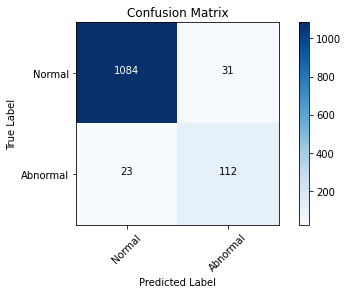

Accuracy : 0.9568
Precision : 0.8812
Recall : 0.9009
F1-score : 0.8907


In [106]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
blsmote_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = blsmote_tree.predict(X_test)
cm_blsmote = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_blsmote, classes)
_, _, _, f1_blsmote = calculate_classification_metrics(y_test, y_pred_test)

## ADASYN

https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html#imblearn.over_sampling.ADASYN

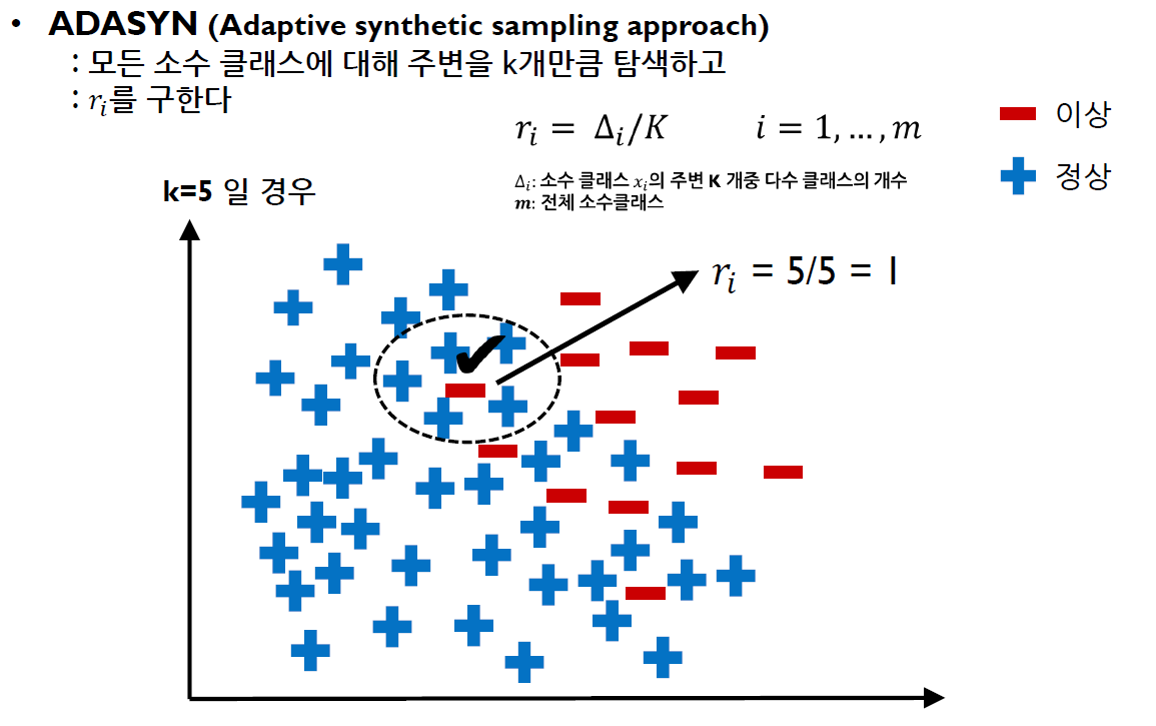

In [107]:
Image.open('./imgs/img8.png')

In [108]:
from imblearn.over_sampling import ADASYN

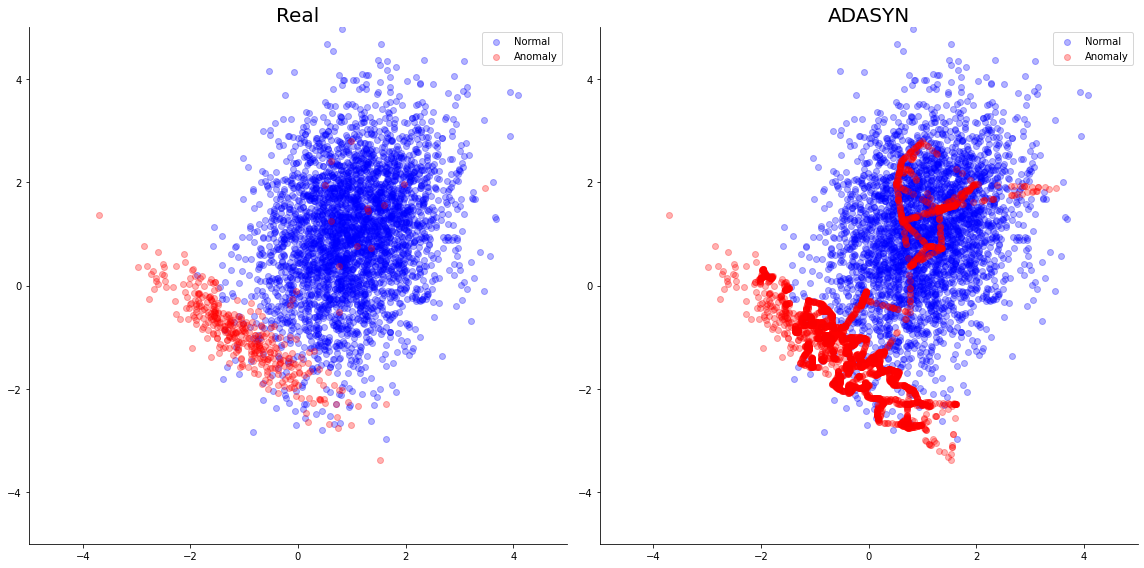

In [109]:
adasyn = ADASYN(sampling_strategy='auto',
                random_state=2023,
                n_neighbors=3)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

plot_representation(X_train, y_train, X_resampled, y_resampled, 'ADASYN')

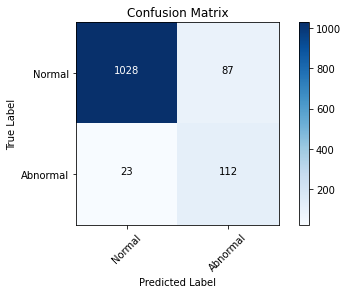

Accuracy : 0.9120
Precision : 0.7705
Recall : 0.8758
F1-score : 0.8099


In [110]:
dt_tree = tree.DecisionTreeClassifier(random_state=2023)
adasyn_tree = dt_tree.fit(X_resampled, y_resampled)

y_pred_test = adasyn_tree.predict(X_test)
cm_adasyn = confusion_matrix(y_test, y_pred_test)

classes = ['Normal','Abnormal']

plot_confusion_matrix(cm_adasyn, classes)
_, _, _, f1_adasyn = calculate_classification_metrics(y_test, y_pred_test)